## Setup

In [37]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# General
from glob import glob
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.metrics import roc_auc_score

# Deep Learning
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

# Plotting
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns


## PARAMS

In [2]:
INPUT_DIR = "../input/g2net-gravitational-wave-detection"
MODELS_DIR = "../models/"

In [83]:
# Load model
model_version = 242
MODEL_DIR = f"{MODELS_DIR}/models_v{model_version:03}"
model = keras.models.load_model(f"{MODEL_DIR}/model_{model_version:03}.h5")

In [68]:
def load_dataset(files, labels=False):
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=None)

    def _parse_function(example_proto):
        if labels:
            keys_to_feature = {
                "TimeSeries": tf.io.FixedLenFeature(([4096,3]), tf.float32),
                "Target": tf.io.FixedLenFeature((), tf.int64, default_value=0)
            }
        else:
            keys_to_feature = {
                "TimeSeries": tf.io.FixedLenFeature(([4096,3]), tf.float32)
            }
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_feature)

        return parsed_features["TimeSeries"], parsed_features["Target"] if labels else parsed_features["TimeSeries"]
    
    # parse the record into tensors
    dataset = dataset.map(_parse_function)
    
#     shuffle the dataset
    if labels:
        dataset = dataset.shuffle(buffer_size=10000)
        # Repeat the input infinitely
#         dataset = dataset.repeat()
        
#     gernerate batches
    dataset = dataset.batch(256)
    dataset = dataset.prefetch(-1)

    return dataset

In [84]:
test_ds = load_dataset("./train_250_Mpc.tfrec")

In [85]:
predictions = model.predict(test_ds)

C:\Users\apist\anaconda3\envs\g2net-tf\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

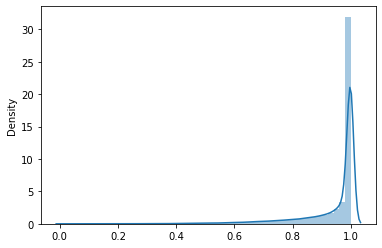

In [86]:
sns.distplot(predictions)

In [87]:
predictions

array([[1.       ],
       [0.9853279],
       [1.       ],
       ...,
       [0.5974317],
       [0.7178038],
       [0.7178038]], dtype=float32)

In [88]:
musterlösung = np.zeros(predictions.shape[0], dtype=np.uint8)
musterlösung[:predictions.shape[0]//2] = 1
musterlösung
roc_auc_score(musterlösung, predictions)

0.8818956602000001

In [17]:
K.clear_session()

In [10]:
test_x = np.load(f"{INPUT_DIR}/test_x.npy")
test_x.shape
results_test = batchwise_prediction(test_x, 4)

0
1
2
3


In [11]:
roc_auc_score(train_y, results)

0.6453767455082405

In [20]:
sub = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv")
sub.target = predictions


In [13]:
# results_test[np.isnan(results_test)] = 1
results.max()

1.0

In [21]:
sub.to_csv("submission1.csv", index=False)